# 1. Fit a function on your bike data
Before we can start with interpreting our model, we need a model that fits
the data reasonably well. In more mathematical terms, that means we would like to have a model that has reasonable $R^2$ or accuraccy on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 

bike = pd.read_csv('bike.csv').iloc[:, 1:]
bike.head()

season    yr mnth     holiday weekday      workingday weathersit      temp  \
0  SPRING  2011  JAN  NO HOLIDAY     SAT  NO WORKING DAY      MISTY  8.175849   
1  SPRING  2011  JAN  NO HOLIDAY     SUN  NO WORKING DAY      MISTY  9.083466   
2  SPRING  2011  JAN  NO HOLIDAY     MON     WORKING DAY       GOOD  1.229108   
3  SPRING  2011  JAN  NO HOLIDAY     TUE     WORKING DAY       GOOD  1.400000   
4  SPRING  2011  JAN  NO HOLIDAY     WED     WORKING DAY       GOOD  2.666979   

       hum  windspeed   cnt  days_since_2011  
0  80.5833  10.749882   985                0  
1  69.6087  16.652113   801                1  
2  43.7273  16.636703  1349                2  
3  59.0435  10.739832  1562                3  
4  43.6957  12.522300  1600                4

In [2]:
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

For control purposes, we add a perfectly correlated feature and one random feature to the test set

In [3]:
def prepare_bike_data(collinear_feature = None):
    bike = pd.read_csv('bike.csv').iloc[:, 1:]
    bike['randvec'] = np.random.rand(bike.shape[0])
    if not collinear_feature is None:
        bike['col_' + collinear_feature] = bike[collinear_feature]
    cat_cols = bike.select_dtypes('object').columns
    non_cat_cols = bike.columns[~bike.columns.isin(cat_cols)]
    enc = preprocessing.OrdinalEncoder()
    enc.fit(bike.loc[:, cat_cols])
    bike.loc[:, cat_cols] = enc.transform(bike.loc[:, cat_cols].values)
    return bike

def prepare_x_y(df, y_col):
    X = df.loc[:, ~df.columns.isin([y_col])].values
    x_cols = df.loc[:, ~df.columns.isin([y_col])].columns
    y = df.loc[:, y_col].values
    return X, y, x_cols

#bike = prepare_bike_data(collinear_feature='days_since_2011')
bike = prepare_bike_data()
X, y, x_cols = prepare_x_y(bike, y_col='cnt')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.2, random_state=42)


In [4]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, 
                           random_state=0)
rf = rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [5]:
r2_score(y_test, y_test_pred)

0.8727254316232366

We note that we get a very impressive $R^2$ of 88%. Lets now use this model for interpretation

Feature ranking:
1. feature 10 (0.629022)
2. feature 7 (0.222919)
3. feature 8 (0.054451)
4. feature 9 (0.030154)
5. feature 6 (0.018796)
6. feature 11 (0.013497)
7. feature 2 (0.009411)
8. feature 4 (0.006904)
9. feature 5 (0.006392)
10. feature 0 (0.005429)
11. feature 3 (0.002661)
12. feature 1 (0.000364)


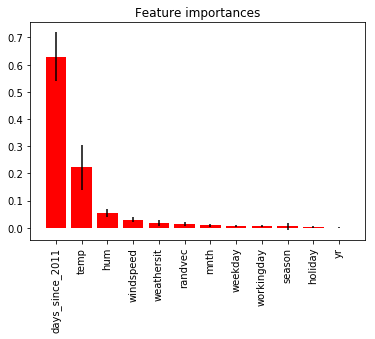

In [6]:
def plot_mdi_feature_importance(forest, x_cols):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #plt.xticks(range(X.shape[1]), indices)
    plt.xticks(range(X.shape[1]), x_cols[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()
plot_mdi_feature_importance(rf, x_cols)

Our standard method (mean decrease impurity) tells us that days since 2011 are the most important features. This hints at a trend, which is confirmed below.

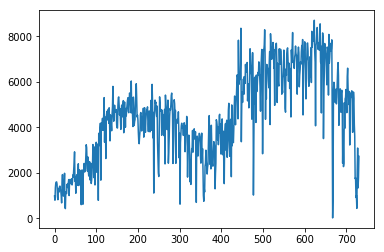

In [7]:
plt.plot(bike['days_since_2011'], bike['cnt'])

We are also interested in the degree of collinearity of our features.
We find that humidity and weather situation have the highest correlation 60%. The rest of our features are reasonably decorrelated

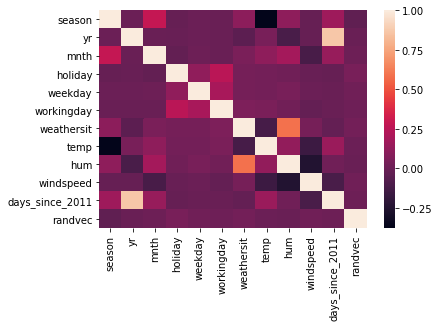

In [8]:
bike.corr()
import seaborn as sns
sns.heatmap(bike.drop('cnt', axis=1).corr())

# 5.1.1 Partial Dependence Plot

In [87]:
y_col = 'cnt'
feature_names = ['temp', 'hum', 'windspeed', 'randvec', 
                 'days_since_2011', 'season']
features = [bike.drop(y_col, axis=1).columns.get_loc(x) 
             for x in feature_names]

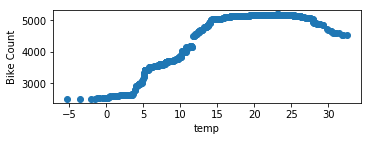

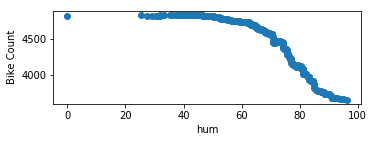

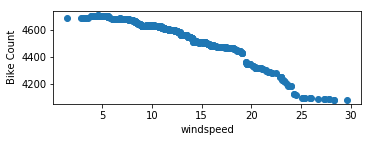

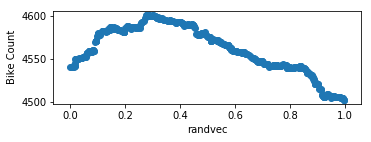

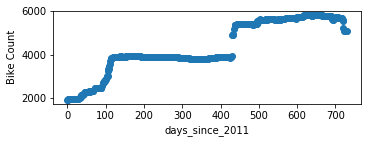

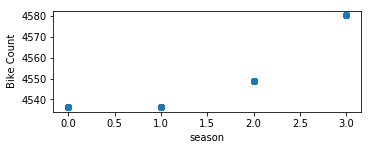

In [89]:
def pdp_plot(X, rf, feature_no, feature_name, y_name, multiplier=100):
    feat_sort_idx = X[:, feature_no].argsort()
    X = X[feat_sort_idx, :]
    n = X.shape[0]
    x_vals = np.vstack([X]*n)
    x_vals[:, feature_no] = np.repeat(X[:, feature_no], n)
    y_vals = rf.predict(x_vals)
    x_vals = np.mean(x_vals[:, feature_no].reshape((n, n)), axis=-1)
    y_vals = np.mean(y_vals.reshape(n, n), axis=-1)
    plt.xlabel(feature_name)
    plt.ylabel(y_name)
    return plt.scatter(x_vals, y_vals)

for i, _ in enumerate(feature_names):
    plt.figure(figsize=(5,10))
    plt.subplot(len(feature_names), 1, i+1)
    plt.tight_layout()
    pdp_plot(X, rf, features[i], feature_names[i], 
          y_name = 'Bike Count')

In [86]:
bike

season    yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1.0  2011   4.0      1.0      2.0         0.0         1.0   8.175849   
1       1.0  2011   4.0      1.0      3.0         0.0         1.0   9.083466   
2       1.0  2011   4.0      1.0      1.0         1.0         0.0   1.229108   
3       1.0  2011   4.0      1.0      5.0         1.0         0.0   1.400000   
4       1.0  2011   4.0      1.0      6.0         1.0         0.0   2.666979   
5       1.0  2011   4.0      1.0      4.0         1.0         0.0   1.604356   
6       1.0  2011   4.0      1.0      0.0         1.0         1.0   1.236534   
7       1.0  2011   4.0      1.0      2.0         0.0         1.0  -0.245000   
8       1.0  2011   4.0      1.0      3.0         0.0         0.0  -1.498349   
9       1.0  2011   4.0      1.0      1.0         1.0         0.0  -0.910849   
10      1.0  2011   4.0      1.0      5.0         1.0         1.0  -0.052723   
11      1.0  2011   4.0      1.0      6.0         1.0         0.0   0.118169   
12      1.0  2011   4.0      1.0      4.0         1.0         0.0  -0.245000   
13      1.0  2011   4.0      1.0      0.0         1.0         0.0  -0.439110   
14      1.0  2011   4.0      1.0      2.0         0.0         1.0   2.966651   
15      1.0  2011   4.0      1.0      3.0         0.0         0.0   2.888349   
16      1.0  2011   4.0      0.0      1.0         0.0         1.0   0.264151   
17      1.0  2011   4.0      1.0      5.0         1.0         1.0   2.183349   
18      1.0  2011   4.0      1.0      6.0         1.0         1.0   5.732178   
19      1.0  2011   4.0      1.0      4.0         1.0         1.0   4.298349   
20      1.0  2011   4.0      1.0      0.0         1.0         0.0   0.342500   
21      1.0  2011   4.0      1.0      2.0         0.0         0.0  -5.220871   
22      1.0  2011   4.0      1.0      3.0         0.0         0.0  -3.463480   
23      1.0  2011   4.0      1.0      1.0         1.0         0.0  -3.422609   
24      1.0  2011   4.0      1.0      5.0         1.0         1.0   2.503466   
25      1.0  2011   4.0      1.0      6.0         1.0         2.0   2.222500   
26      1.0  2011   4.0      1.0      4.0         1.0         0.0   1.165000   
27      1.0  2011   4.0      1.0      0.0         1.0         1.0   1.563466   
28      1.0  2011   4.0      1.0      2.0         0.0         0.0   1.236534   
29      1.0  2011   4.0      1.0      3.0         0.0         0.0   2.176534   
..      ...   ...   ...      ...      ...         ...         ...        ...   
701     3.0  2012   2.0      1.0      3.0         0.0         1.0   8.332500   
702     3.0  2012   2.0      1.0      1.0         1.0         0.0  13.267500   
703     3.0  2012   2.0      1.0      5.0         1.0         0.0  14.364151   
704     3.0  2012   2.0      1.0      6.0         1.0         0.0  12.601651   
705     3.0  2012   2.0      1.0      4.0         1.0         0.0   4.024151   
706     3.0  2012   2.0      1.0      0.0         1.0         1.0   7.079151   
707     3.0  2012   2.0      1.0      2.0         0.0         1.0   9.938349   
708     3.0  2012   2.0      1.0      3.0         0.0         1.0  10.055849   
709     3.0  2012   2.0      1.0      1.0         1.0         1.0  12.484151   
710     3.0  2012   2.0      1.0      5.0         1.0         1.0   8.606651   
711     3.0  2012   2.0      1.0      6.0         1.0         1.0   5.982500   
712     3.0  2012   2.0      1.0      4.0         1.0         0.0   5.904151   
713     3.0  2012   2.0      1.0      0.0         1.0         0.0   5.238349   
714     3.0  2012   2.0      1.0      2.0         0.0         0.0   7.235849   
715     3.0  2012   2.0      1.0      3.0         0.0         1.0   9.037500   
716     3.0  2012   2.0      1.0      1.0         1.0         1.0  10.486651   
717     3.0  2012   2.0      1.0      5.0         1.0         0.0  11.309151   
718     3.0  2012   2.0      1.0      6.0         1.0         0.0   7.627500   
719  

In [79]:
y_vals.shape

(584,)

In [68]:
x_vals.shape

(341056, 12)

In [69]:
y_vals.shape

(341056,)

In [75]:
np.mean(x_vals.reshape((X.shape[0], X.shape[1], X.shape[0])), axis=-1).shape

(584, 12)

In [44]:
np.expand_dims(X, axis=-1).shape

(584, 12, 1)

In [41]:
X.shape

(584, 12)

In [45]:
np.dstack([X]*X.shape[0])

(584, 12, 584)

In [61]:
X_t = np.array([[1, 2, 3], [4, 5, 6]])
X_test = np.vstack([X_t]*3)
np.repeat(X_t[:, 2], 3)


array([3, 3, 3, 6, 6, 6])

In [ ]:
    n = X.shape[0]
    sim_num = n*multiplier
    sims = [np.expand_dims(np.random.choice(X[:, i], sim_num), axis=1)
            for i in range(X.shape[1])]
    sims = np.concatenate(sims, axis=1)
    sims[:, feature_no] = np.repeat(X[:, feature_no], multiplier)
    y_sims = rf.predict(sims)
    x_val = np.mean(sims[:, feature_no].reshape((n, multiplier)), axis=1)
    y_val = np.mean(y_sims.reshape((n, multiplier)), axis=1)
    plt.xlabel(feature_name)
    plt.ylabel(y_name)
    return plt.scatter(x_val, y_val)

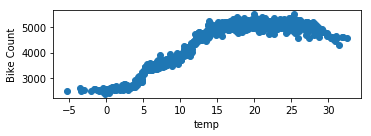

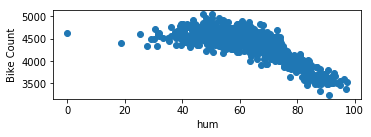

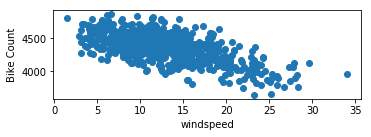

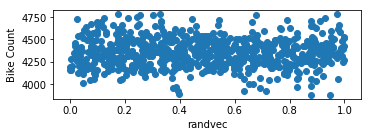

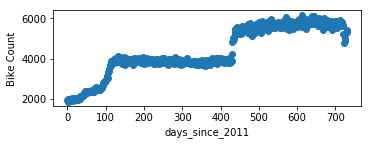

In [258]:
def pdp_plot(X, rf, feature_no, feature_name, y_name, multiplier=100):
    n = X.shape[0]
    sim_num = n*multiplier
    sims = [np.expand_dims(np.random.choice(X[:, i], sim_num), axis=1)
            for i in range(X.shape[1])]
    sims = np.concatenate(sims, axis=1)
    sims[:, feature_no] = np.repeat(X[:, feature_no], multiplier)
    y_sims = rf.predict(sims)
    x_val = np.mean(sims[:, feature_no].reshape((n, multiplier)), axis=1)
    y_val = np.mean(y_sims.reshape((n, multiplier)), axis=1)
    plt.xlabel(feature_name)
    plt.ylabel(y_name)
    return plt.scatter(x_val, y_val)

for i, _ in enumerate(feature_names):
    plt.figure(figsize=(5,8))
    plt.subplot(len(feature_names), 1, i+1)
    plt.tight_layout()
    pdp_plot(X, rf, features[i], feature_names[i], 
          y_name = 'Bike Count')

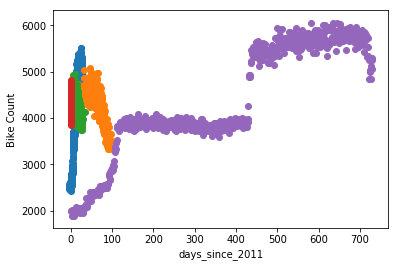

In [259]:
plot_dicts = {feature_names[i]: pdp_plot(X, rf, f, feature_names[i], 
          'Bike Count') for i, f in enumerate(features)}